<a href="https://www.kaggle.com/code/ritvik1909/text-classification-attention" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Text Classification Using Attention and Positional Embeddings

Recently most of the natural language processing tasks are being dominated by the `Transformer` architecture. Transformers were introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762), which used a simple mechanism called `Neural Attention` as one of its building blocks. As the title suggests this architecture didn't require any recurrent layer.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

We will be using 20 news groups data in our notebooks which comes as a standard dataset in the `scikit-learn` package

In [2]:
dataset = fetch_20newsgroups(subset='all')

X = pd.Series(dataset['data'])
y = pd.Series(dataset['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=19)
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)

The concept of `Neural Attention` is fairly simple ie not all input information seen by a model is equally important to the task at hand. Although this concept has been utilised at vaious different places as well eg Max Pooling in CNNs, but the kind of attention we are looking for should be `context aware`.

The attention mechanism allows output to focus attention on input while producing output while the self-attention model allows inputs to interact with each other i.e calculate attention of all other inputs with respect tt one input.

In the paper, the authors proposed another type of attention mechanism called multi-headed attention which refers to the fact that the outer space of the self attention layer gets factored into a set of independent sub-spaces leanred separately, where each subspace is called a "head"

There is a learnable dense projection present after the multihead attention which enables the layr to actually learn something, as opposed to being a purely stateless transformation.



In [3]:
class TransformerBlock(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

The idea behind Positional Encoding is fairly simple as well, ie to give the model access to token order information, therefore we are going to add the token's position in the sentence to each word embedding

Thus, one input word embedding will have to components: the usual token vector representing the token independent of any specific context, and a position vector representing the position of the token in the current sequence.

In [4]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = L.Embedding(input_dim, output_dim)
        self.position_embeddings = L.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

Here we define some contants to parameterize the model

In [5]:
vocab_size = 10_000
embed_dim = 256
num_heads = 2
dense_dim = 32
seq_length = 256

The input texts are here tokenized and padded to a uniform sequence length

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<unw>')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(X_train, maxlen=seq_length)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = sequence.pad_sequences(X_valid, maxlen=seq_length)

**Defining the model**
The model architecture is fairly simple ie,:
* Input Layer
* Positional Embeddings
* Transformer Block
* Pooling
* Dropout
* Output Layer

In [7]:
inputs = keras.Input(shape=(None, ), dtype="int64")
x = PositionalEmbedding(seq_length, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, dense_dim, num_heads)(x)
x = L.GlobalMaxPooling1D()(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(20, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        2625536   
 ionalEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, None, 256)        543776    
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [9]:
es = keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
    callbacks=[es, rlp], epochs=100
)

Epoch 1/100
531/531 [==============================] - 38s 61ms/step - loss: 2.4192 - accuracy: 0.3540 - val_loss: 0.8035 - val_accuracy: 0.7676 - lr: 0.0010
Epoch 2/100
531/531 [==============================] - 31s 59ms/step - loss: 0.6457 - accuracy: 0.8065 - val_loss: 0.4755 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 3/100
531/531 [==============================] - 32s 60ms/step - loss: 0.2459 - accuracy: 0.9263 - val_loss: 0.4804 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 4/100
531/531 [==============================] - 32s 59ms/step - loss: 0.1157 - accuracy: 0.9647 - val_loss: 0.5709 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 5/100
530/531 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9793
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
531/531 [==============================] - 31s 59ms/step - loss: 0.0670 - accuracy: 0.9793 - val_loss: 0.6382 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 6/100
531/531 [===========================

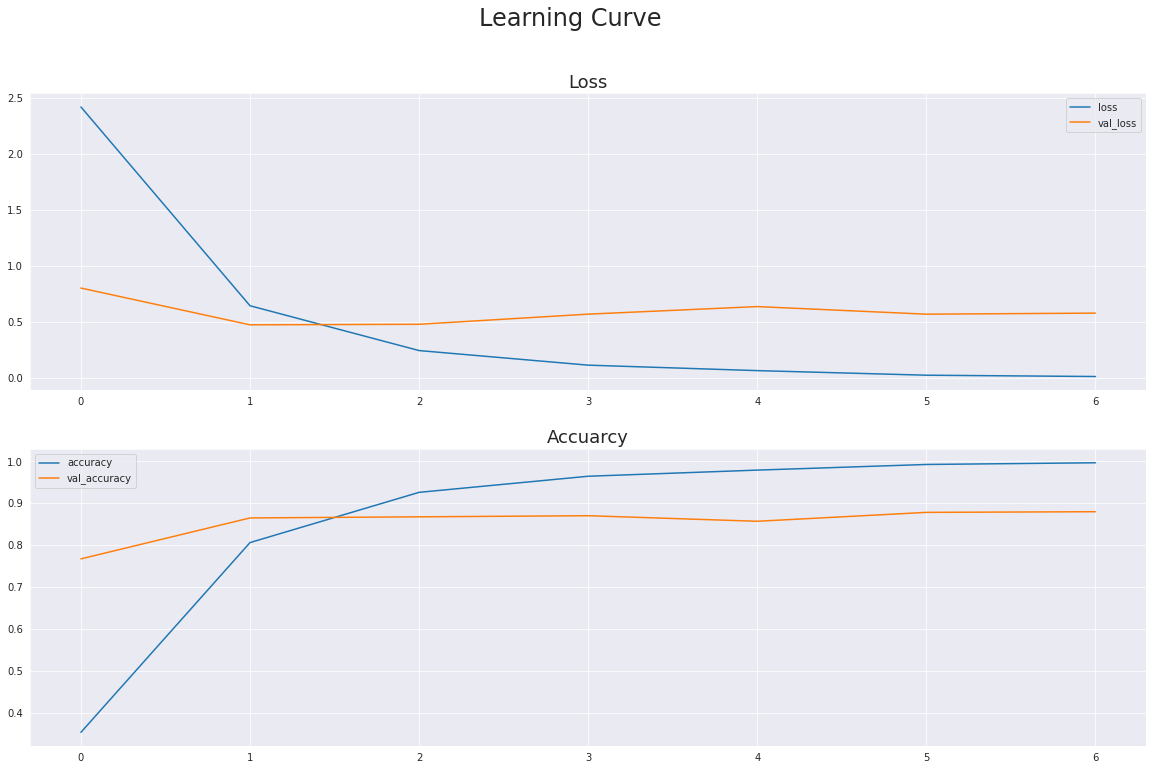

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

history = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
fig.suptitle('Learning Curve', fontsize=24)
history[['loss', 'val_loss']].plot(ax=ax[0])
history[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Loss', fontsize=18)
ax[1].set_title('Accuarcy', fontsize=18);